# Intro

In the previous lesson, we looked at some examples of the movie embeddings we learned, measured the distances between pairs of movies, looked up movies most similar to certain movies, and had some fun composing the semantics of movies with vector math. These are great ways to debug an embedding model, or understand how it works. But it's also pretty time-consuming.

In this lesson you'll learn how to use the T-SNE algorithm to visualize embeddings. This is a nice cheap technique for understanding the nature of your embeddings.

# T-SNE?

Visualizing data in 1 or 2 dimensions is easy - but it's not clear how to visualize embeddings which are 8-dimensional or 32-dimensional. T-SNE is a **dimensionality reduction** algorithm which is often used for visualization. It learns a mapping from a set of high-dimensional vectors, to a space with a smaller number of dimensions (usually 2), which is hopefully a good representation of the high-dimensional space.

What makes a mapping a "good representation"? Put simply, T-SNE tries to make sure that if high-dimensional vectors $u$ and $v$ are close together, then $map(u)$ and $map(v)$ are close together in the 2-d mapping space.

# The code

To start, we'll load our pretrained embeddings, like before.

In [ ]:
#$HIDE$
%matplotlib inline
import random
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

RUNNING_ON_KERNELS = 'KAGGLE_WORKING_DIR' in os.environ
input_dir = '../input/0-movielens-preprocessing' if RUNNING_ON_KERNELS else '../input/movielens_preprocessed'
model_dir = '../input/x3-movielens-spiffy-model' if RUNNING_ON_KERNELS else '.'
model_path = os.path.join(model_dir, 'movie_svd_model_32.h5')

#model = keras.models.load_model('movie_svd_model_32_dropout.h5')
model = keras.models.load_model(model_path)
emb_layer = model.get_layer('movie_embedding')
(w,) = emb_layer.get_weights()

movies_path = os.path.join(input_dir, 'movie.csv')
movies_df = pd.read_csv(movies_path, index_col=0)

As we saw in our earlier lesson, our dataset has lots of obscure movies with few ratings (sometimes as few as one). We know so little about these movies that their embeddings are as good as random. We can clarify our visualization by selecting only movies that meet some popularity threshold.

In [ ]:
threshold = 100
mainstream_movies = movies_df[movies_df.n_ratings >= threshold].reset_index(drop=True)
print("Went from {} to {} movies after applying threshold".format(
    len(movies_df), len(mainstream_movies),
))
w_full = w
w = w[mainstream_movies.movieId]
df = mainstream_movies

Went from 26744 to 8546 movies after applying threshold


We'll be using [scikit-learn's T-SNE implementation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

I mentioned that T-SNE tries to preserve "closeness" between entities in the feature space. As we saw in the previous lessons, there are a lot of competing notions of distance. By default, T-SNE uses euclidean distance. But because cosine distance is known to work well on embeddings, we'll pass in `metric="cosine"` when creating the model.

There are a lot of other parameters we can tweak (if you're curious, you can check them out [in the docs](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)), but for now we'll leave them all to their default values.

In [ ]:
from sklearn.manifold import TSNE

# TODO: probably worth running for more than 1k iters, given trajectory of error
tsne = TSNE(random_state=1, n_iter=1000, metric="cosine")
            
embs = tsne.fit_transform(w)
# Add to dataframe for convenience
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]

Here's a sample of the 2-d vectors we've mapped our movies to:

In [ ]:
embs[:5]

array([[-57.638126,  43.305687],
       [-62.956085, -41.556736],
       [-55.256577,  22.158503],
       [-50.91187 , -35.302444],
       [-15.095206, -24.212475]], dtype=float32)

The whole point of doing this dimensionality reduction was visualization, so let's use matplotlib to draw a scatter plot of our movies, using our new 2-d mapping.

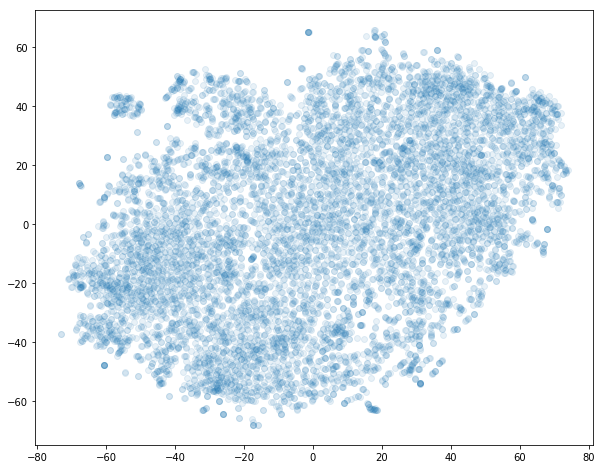

In [ ]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df.x, df.y, alpha=.1);

Did it work? It's hard to judge by the shape alone. A good sanity check is to identify some groups of movies that we strongly believe *should* be close together, and see whether they're close in the 2-d space.

For example, all the Harry Potter movies should be close together, right?

In [ ]:
#$HIDE$
# Some helper functions for plotting annotated T-SNE visualizations

# TODO: adjust_text not available in kernels
if not RUNNING_ON_KERNELS:
    from adjustText import adjust_text
else:
    def adjust_text(*args, **kwargs):
        pass

def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def plot_groups(index_groups, labels, text=False, marker='o', alpha=1, s=None, **kwargs):
    assert not text
    ax = plot_bg(**kwargs)
    for indices, label in zip(index_groups, labels):
        x = embs[indices, 0]
        y = embs[indices, 1]
        ax.scatter(x, y, label=label, alpha=alpha, marker=marker, s=s)
    plt.legend()


    
def plot_title_patterns(patterns, **kwargs):
    index_groups = [
        df[df.title.str.contains(patt)].index
        for patt in patterns
    ]
    plot_groups(index_groups, patterns, **kwargs)

def annotate_sample(n, n_ratings_thresh=0):
    """Plot our embeddings with a random sample of n movies annotated.
    Only selects movies where the number of ratings is at least n_ratings_thresh.
    """
    sample = mainstream_movies[mainstream_movies.n_ratings >= n_ratings_thresh].sample(
        n, random_state=1)
    plot_with_annotations(sample.index)

def plot_by_title_pattern(pattern, **kwargs):
    match = df[df.title.str.contains(pattern)]
    return plot_with_annotations(match.index, text=True, **kwargs)

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = embs
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    if text:
        # TODO: Add abbreviated title column
        titles = mainstream_movies.loc[label_indices, 'title'].values
        texts = []
        for label, x, y in zip(titles, Xlabeled, Ylabeled):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, 
                    #expand_text=(1.01, 1.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                   )
    return ax

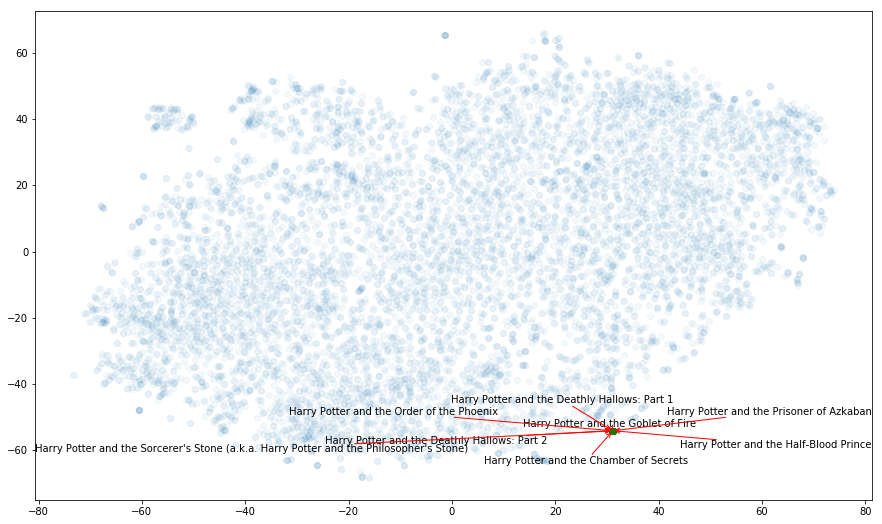

In [ ]:
plot_by_title_pattern('Harry Potter', figsize=(15, 9), bg_alpha=.05);

Wow, they're super-close - basically on top of each other. That's a good sign.

#### DB: I again think covering it multiple times is getting too far into the specifics of movies (which users didn't come to Learn for) and too far from learning skills which users are coming for (because they have life goals that benefit from knowing these techniques).

Let's try a bunch of movie franchises:

/home/colinmorris/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


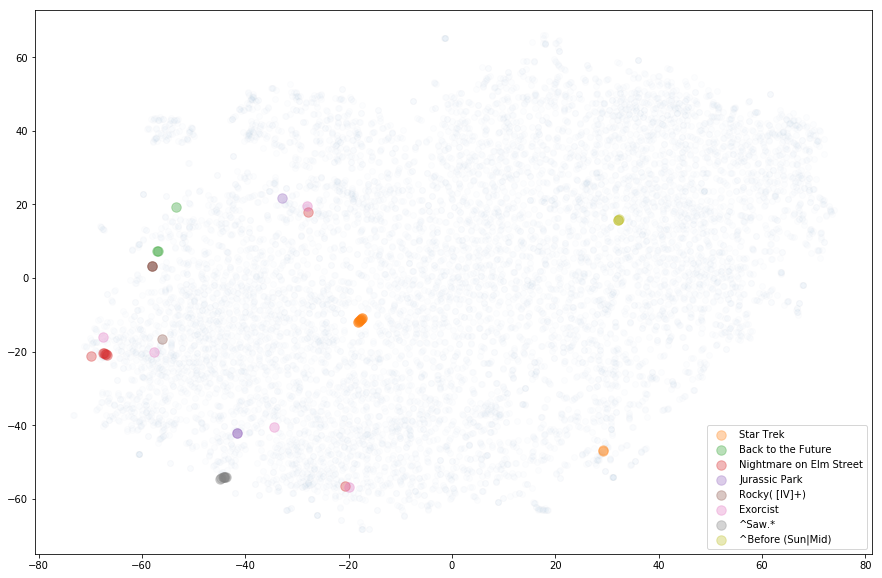

In [ ]:
# TODO: Really hard to count the number of overlapping points when they're exactly on top of each other.
# maybe need to do some kind of repulsive force between points (I think adjust_text might have this facility)
plot_title_patterns([
    #'Harry Potter', 'Star Wars: Episode', 'Terminator',
    'Star Trek', 'Back to the Future', 'Nightmare on Elm Street',
    'Jurassic Park', 'Rocky( [IV]+)', 'Exorcist', '^Saw.*',
    '^Before (Sun|Mid)',
], bg_alpha=.01, alpha=.33, marker='o', figsize=(15, 10), s=90)

Some franchises (*Nightmare on Elm Street*, *Saw*) are super tightly clustered like the *Harry Potter* movies. Others are a bit more spread out (e.g. the *Exorcist* series) or have one or two 'black sheep' members (e.g. *Star Trek*. The smaller island is the 2009 reboot and its sequel, both directed by J.J. Abrams - I think the model is actually justified in separating them from the *Star Trek* films of the 80s and 90s). Overall, seems pretty cohesive.

But one of the key features of T-SNE which makes it so good for visualization is that it's good at capturing clusters *at multiple scales*. We've seen that our mapping is successfully capturing small, tight, local structures. What about bigger structure?

Of course *A Nightmare on Elm Street* should be close to *A Nightmare on Elm Street II*, but it also should be (and is) close to movies from the *Exorcist* series, since they all belong to the category of horror movies. Genres are a good example of a more medium-scale grouping.

Where do documentaries fall?

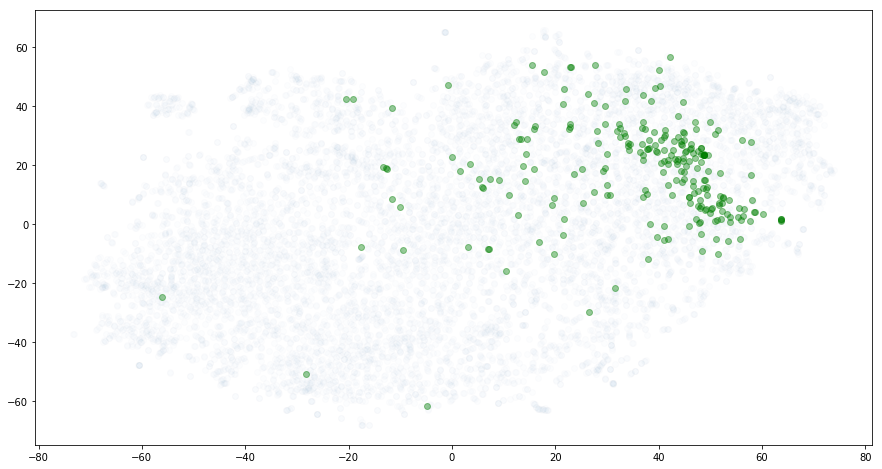

In [ ]:
docs = df[ (df.genres == 'Documentary') ]
plot_with_annotations(docs.index, text=False, alpha=.4, figsize=(15, 8));

Cool - they're almost all in the top-right lobe, with a particularly concentrated strip around (45, 20).

And just to reiterate: we never actually showed the model genre as a feature. It can't read the titles to see that *Harry Potter and the Philosopher's Stone* and *Harry Potter and the Chamber of Secrets* belong to the same series. It managed to pick up these latent patterns and incorporate them into the embedding space just by seeing data points like "user 5299 gave movie 806 a rating of 4.5". Pretty impressive!

Here's another, slightly more complicated genre experiment: visualizing all movies whose genres are a subset of `{Comedy, Drama, Romance}` (i.e. comedies, dramas, romances, dramedies, romantic dramas, romcoms, and... "dromcoms" I guess?)

#### DB: I don't think we can assume users know itertools. But I also think we need to justify to the user what reusable skill they are learning here if we are going to keep it.

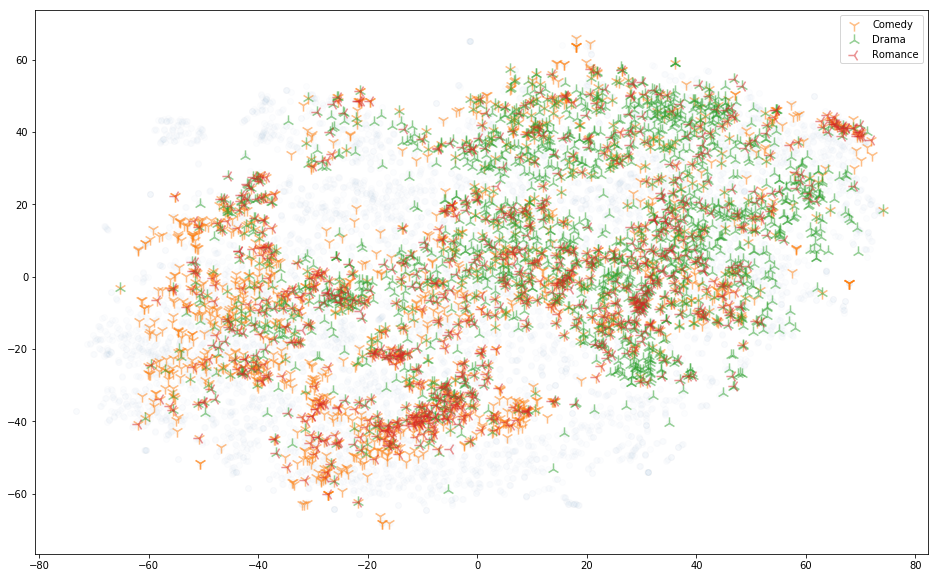

In [ ]:
# experiment: dromcom bitmasks
# TODO: I wonder if sampling would mitigate the overlap problem and make this a bit more readable?
import itertools
genre_components = ['Comedy', 'Drama', 'Romance']
genre_combos = set()
for size in range(1, 4):
    combo_strs = ['|'.join(genres) for genres in itertools.combinations(genre_components, size)]
    genre_combos.update(combo_strs)

ax = plot_bg(figsize=(16, 10))
dromcoms = df[df.genres.isin(genre_combos)]
for i, genre in enumerate(genre_components):
    m = dromcoms[dromcoms.genres.str.contains(genre)]
    marker = str(i+1)
    add_annotations(ax, m.index, label=genre, alpha=.5, marker=marker, s=150, linewidths=5)
plt.legend();

This is an awesome example of structure at the largest scale. Dramas are mostly in the upper-right half, and comedies are mostly in the other half (with romances having a more spread-out, bursty distribution). It's interesting that we saw a similar split with documentaries being in the top-right and the blockbuster franchise movies being in the bottom-left. It seems like the high-level pattern is high-brow / serious / critically acclaimed movies in the top-right, and schlock in the bottom-left?

# Tuning T-SNE

We achieved good results using the default out-of-the box parameters for our T-SNE model, but depending on the characteristics of your data, you may not be so lucky.

T-SNE isn't a simple closed-form mathematical operation. You're training a model to minimize some non-convex loss function using stochastic gradient descent. It may take a while, and require a bit of fiddling. You may even see very different results between two T-SNE models trained with the same parameters (set a fixed `random_state` if you want reproducibility).

When tuning, I highly recommend creating your model with `verbose = True` to see what's happening during fitting. Among other things, it will report the error and the the gradient size every 50 iterations, which can help guide experimentation. For example, if the error rate is still decreasing after 1000 iterations (the default value of `n_iter`), you may want to try running it for more iterations next time.

The [sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) have good information on the meaning of each parameter, and some tips for setting them. But I want to give a bit of attention to one especially important parameter which is particular to T-SNE: **perplexity**.

# Perplexity?

Again, the goal of T-SNE is to ensure that points which are close in the feature space are close in the 2-d mapping. The mapping preserves "closeness" - *not* distance. i.e. it's not a big deal if entities that were widely separated in the feature space end up nearby in the 2-d space.

So how close is close? This is more or less what perplexity controls. Small perplexities mean we only care about pairs that are really close - emphasizing *local* structure. Larger perplexities lead to us considering more neighbours to each point - emphasizing more *global* structure.

Let's try a few different perplexities and see how it affects the overall shape of our 2-d mapping.

In [ ]:
import time
t0 = time.time()
ppx_to_embs = {}
if RUNNING_ON_KERNELS:
    perplexities = [3, 10, 30, 90, 270, 900]
else:
    perplexities = [3, 10, 30, 90]
for ppx in perplexities:
    print(ppx)
    model = TSNE(random_state=1, n_iter=1500, perplexity=ppx, verbose=2)
    ppx_to_embs[ppx] = model.fit_transform(w)
print("Finished in {} seconds".format(time.time()-t0))

In [ ]:
# timesaver while iterating
import pickle
if 0:
    with open('ppx_to_embs.pickle', 'wb') as f:
        pickle.dump(ppx_to_embs, f)

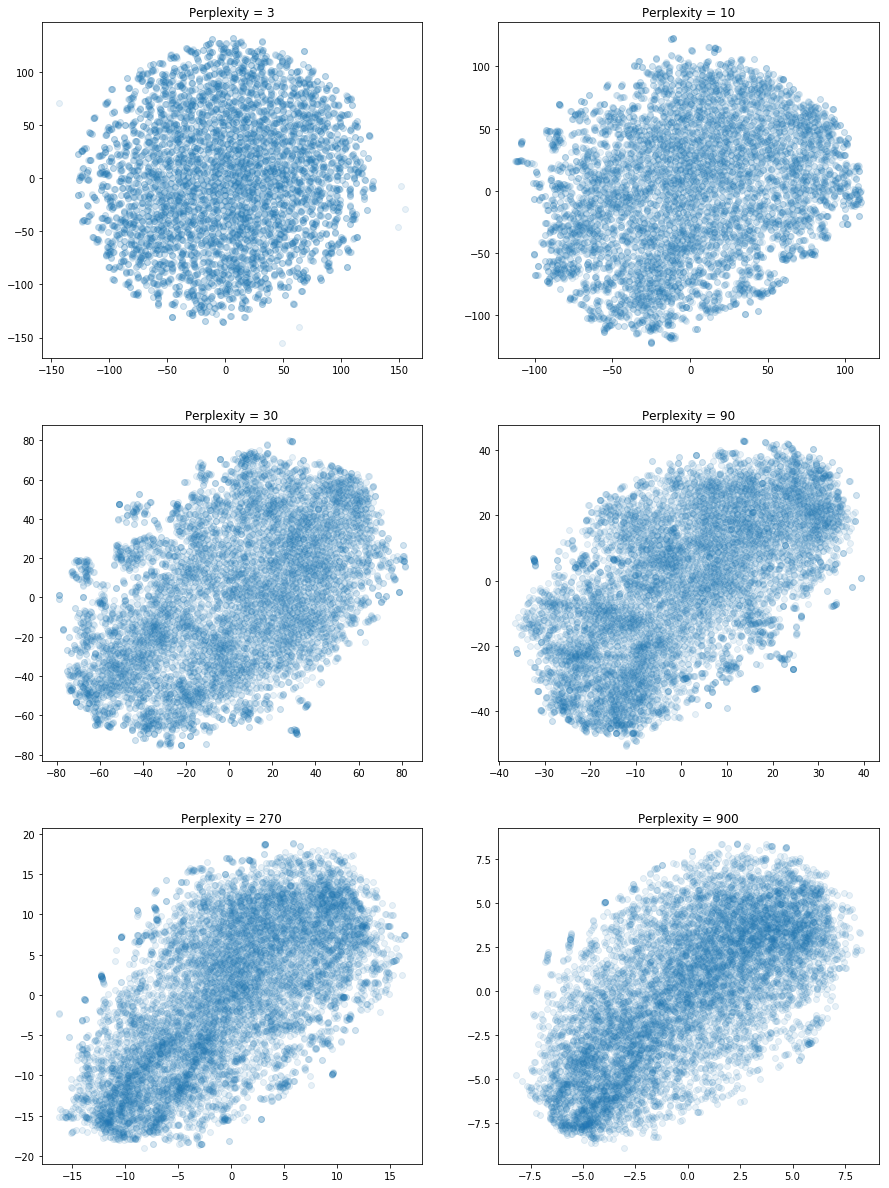

In [ ]:
FS = (15, 21)
perplexities = [3, 10, 30, 90, 270, 900]
fig, axes = plt.subplots(3, 2, figsize=FS)
for ax, ppx in zip(axes.flatten(), perplexities):
    emb = ppx_to_embs[ppx]
    ax.scatter(emb[:, 0], emb[:, 1], alpha=.1)
    ax.set_title('Perplexity = {}'.format(ppx))

The ball of evenly-spaced clumps in the first subplot is a classic symptom of the perplexity being set too low. In its focus on local structure, the model has identified a bunch of tiny, isolated clusters (some of them probably spurious), and it doesn't really care where they land relative to each other, as long as they're preferably not overlapping - hence the spaced out circle.

As perplexity increases, we see more non-local structure emerging. If we turn it up way too high (the typical recommended range is [5, 50]) the small and medium-scale structures start getting smoothed out, in favour of enforcing global structure.

Click the "output" buttons below to see what our earlier genre experiments look like if we apply them to our models trained with different perplexities.

**TODO: maybe instead do one genre experiment, and one experiment showing small-scale clusters**

#### DB: I think users need more context on when they shuold use what you are showing them below in their own projects. What decisions could it inform?

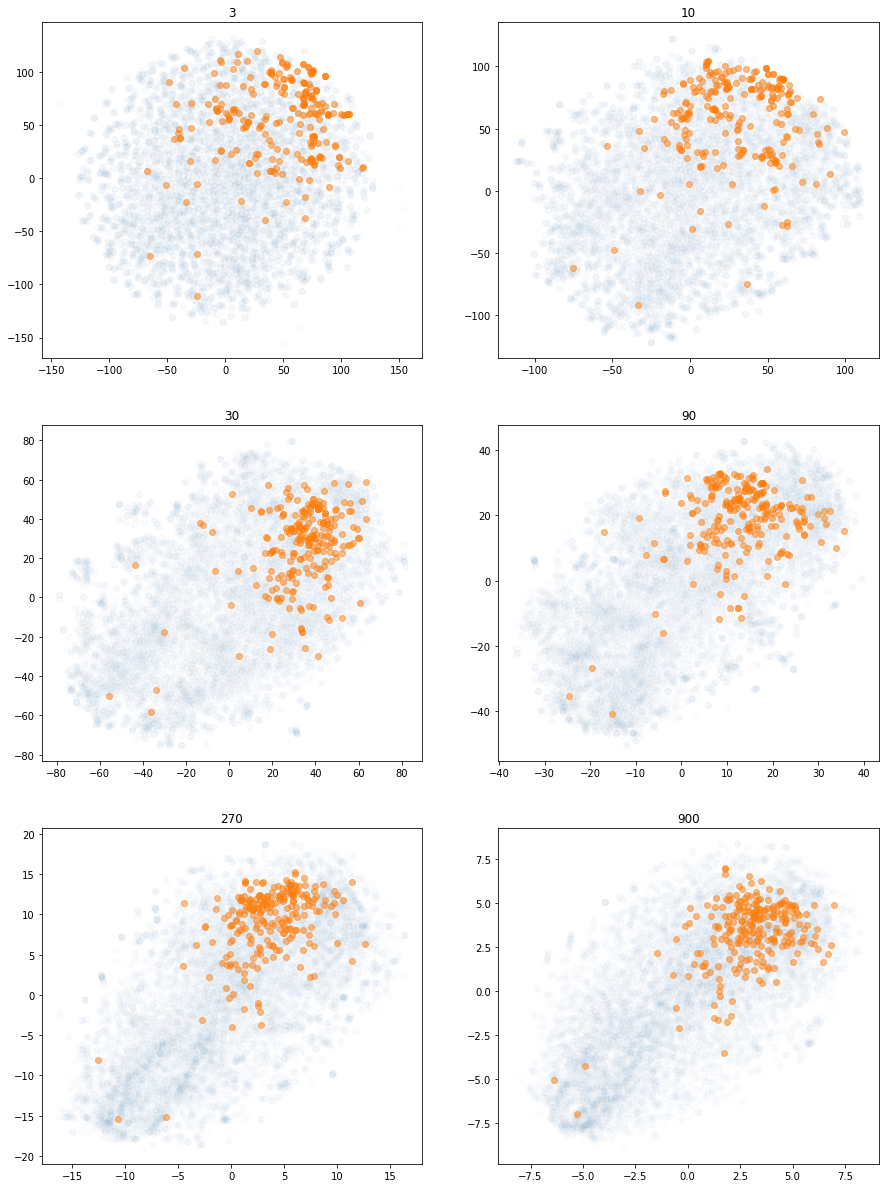

In [ ]:
#$HIDE$
FS = (15, 21)
bg_alpha = .01
fig, axes = plt.subplots(3, 2, figsize=FS)
docs = df[ (df.genres == 'Documentary') ]
for ax, ppx in zip(axes.flatten(), perplexities):
    emb = ppx_to_embs[ppx]
    X = emb[:, 0]
    Y = emb[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    ax.set_title(ppx)
    add_annotations(ax, docs.index, emb_2d=emb, alpha=.5)


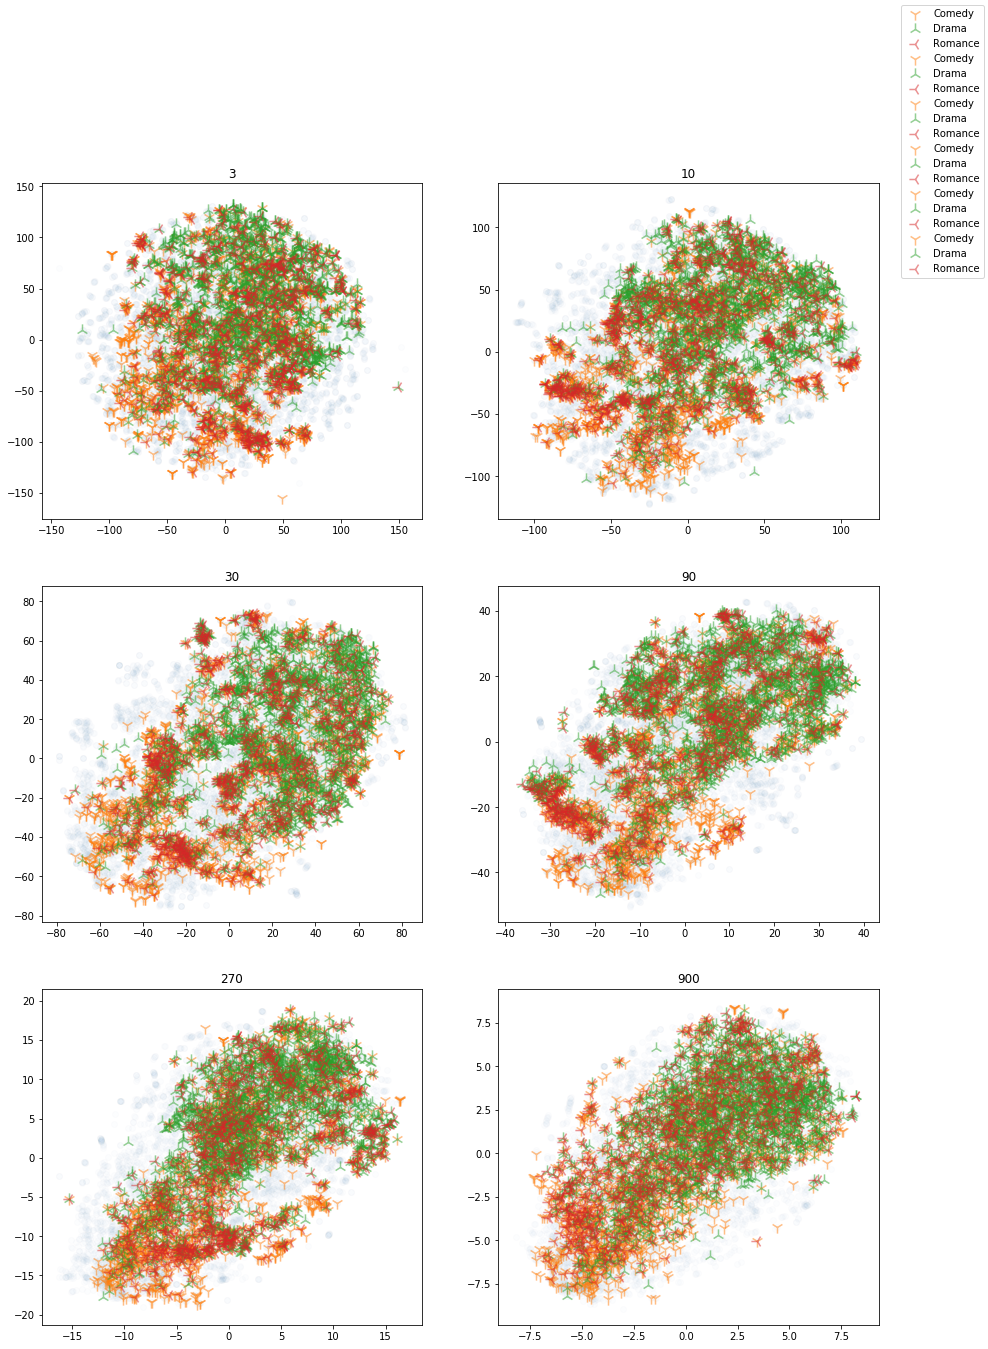

In [ ]:
#$HIDE$
import itertools
def plot_dromcoms(e, ax):
    genre_components = ['Comedy', 'Drama', 'Romance']
    genre_combos = set()
    for size in range(1, 4):
        combo_strs = ['|'.join(genres) for genres in itertools.combinations(genre_components, size)]
        genre_combos.update(combo_strs)

    if ax is None:
        ax = plot_bg(figsize=(16, 10))
    dromcoms = df[df.genres.isin(genre_combos)]
    for i, genre in enumerate(genre_components):
        m = dromcoms[dromcoms.genres.str.contains(genre)]
        marker = str(i+1)
        add_annotations(ax, m.index, emb_2d=e, label=genre, alpha=.5, marker=marker, s=150, linewidths=5)
    
FS = (15, 21)
bg_alpha = .01
fig, axes = plt.subplots(3, 2, figsize=FS)
for ax, ppx in zip(axes.flatten(), perplexities):
    emb = ppx_to_embs[ppx]
    X = emb[:, 0]
    Y = emb[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    ax.set_title(ppx)
    plot_dromcoms(emb, ax)
fig.legend();

These patterns are actually pretty darn robust, even when we choose extreme perplexities. Which model is the best? Well our goal here is just effectively visualizing the high-dimensional data, so it's ultimate a subjective question. At a glance, 10, 30, and 90 all seem to do a pretty good job of separating the roms from the coms and the drams, and all produce some interesting clustering patterns of varying sizes, shapes, and degrees of connectedness. We'd have to investigate more deeply to decide which ones seemed the most grounded in reality.

# Your Turn



**TODO: exercise link**

# Further Reading

- If you're interested in more in-depth, mathematical detail on T-SNE, I highly recommend checking out [the original paper by Laurens van der Maaten and Geoff Hinton that introduced T-SNE to the world](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).
- [How to Use t-SNE effectively](https://distill.pub/2016/misread-tsne/) features some incredible live, interactive examples, allowing you to apply T-SNE to various synthetic datasets and watch the training happen in real-time, and see the effect of changing parameters like the perplexity.
- [scikit-learn's t-SNE user guide](http://scikit-learn.org/stable/modules/manifold.html#t-sne)
- [t-SNE FAQ](https://lvdmaaten.github.io/tsne/#faq) written by Laurens van der Maaten

`</tutorial>`

# Scratch space below - please ignore

What if it sucks?

Don't panic! Sometimes you'll need to do a little fiddling with parameters to get good results.

The first knob you'll want to play with is **perplexity**.

# Perplexity?

Again, the goal of T-SNE is to ensure that points which are close in the feature space are close in the 2-d mapping. The mapping preserves "closeness" - *not* distance. i.e. it's not a big deal if entities that were widely separated in the feature space end up as neighbours in the 2-d space.

So how close is close? This is more or less what perplexity controls. Small perplexities mean we only care about pairs that are really close - emphasizing *local* structure. Larger perplexities lead to us considering more neighbours to each point.

Let's try a few different perplexities and see how it affects the overall shape of our 2-d mapping.

[...]

Two reasons to think we should try a lower perplexity:
- overall 'blob-like' shape and lack of structure
- We know that, for example, the movies in the Harry Potter and Star Wars series are each other's nearest neighbours. But they're not landing near each other in the map space. Want more emphasis on local structure, not global.

(If you're interested in more mathematical detail on perplexity, I highly recommend checking out [the paper that introduced T-SNE](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).)

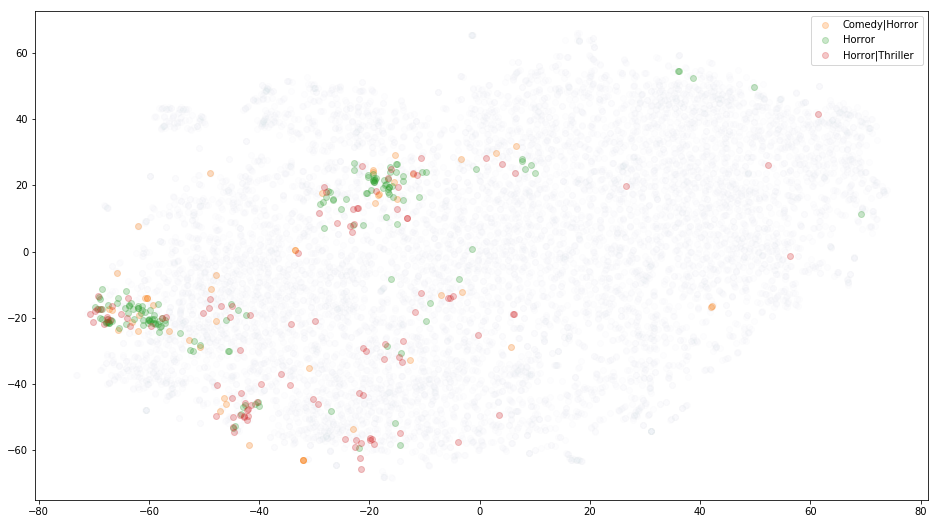

In [ ]:
genre_counts = df.groupby('genres').size()
horror_genres = genre_counts[
    (genre_counts >= 45) & (genre_counts.index.str.contains('Horror'))
].index
sub = df[df.genres.isin(horror_genres)]
g = sub.groupby('genres')

ax = plot_bg(figsize=(16, 9), bg_alpha=.006)

for genre, group in g:
    add_annotations(ax, group.index, label=genre, alpha=.25)
plt.legend();

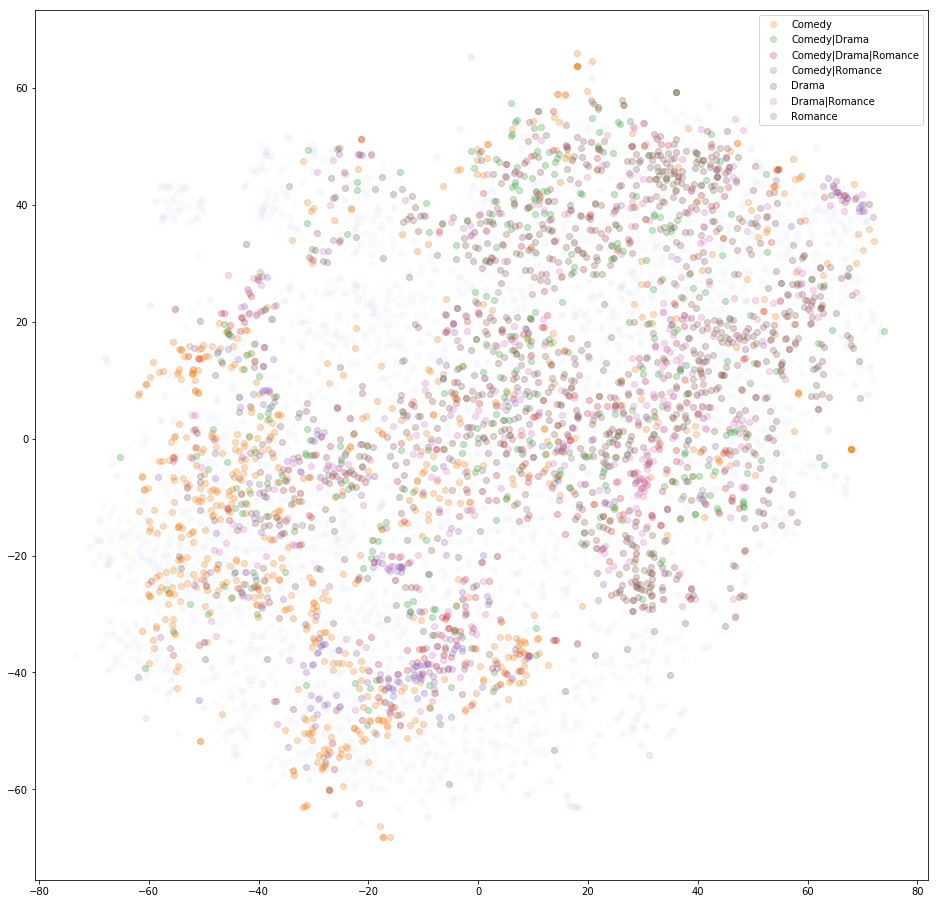

In [ ]:
# dromcoms 2
import itertools
genre_components = ['Comedy', 'Drama', 'Romance']
genre_combos = set()
for size in range(1, 4):
    combo_strs = ['|'.join(genres) for genres in itertools.combinations(genre_components, size)]
    genre_combos.update(combo_strs)

ax = plot_bg(figsize=(16, 16))
dromcoms = df[df.genres.isin(genre_combos)]
g = dromcoms.groupby('genres')
for genre, group in g:
    add_annotations(ax, group.index, label=genre, alpha=.25)
plt.legend();

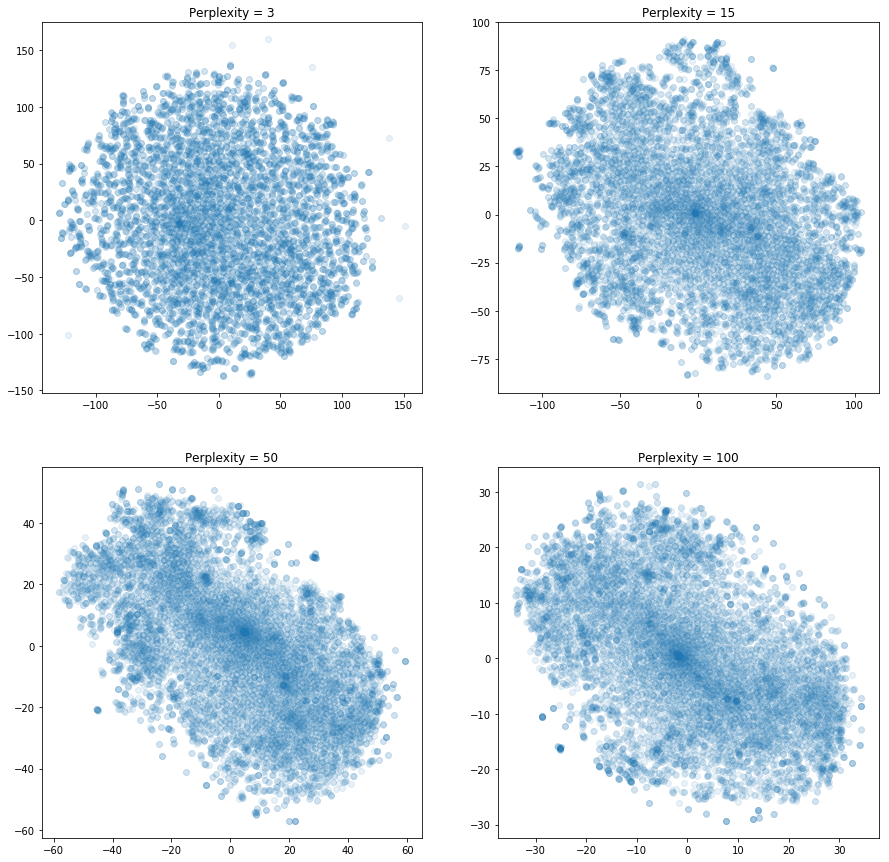

In [ ]:
FS = (15, 15)
fig, axes = plt.subplots(2, 2, figsize=FS)
perplexities = [3, 15, 50, 100]
# Oof, this is sloooow
for ax, ppx in zip(axes.flatten(), perplexities):
    tsne = TSNE(random_state=1, verbose=0, n_iter=1500,
                perplexity=ppx
           )
    emb = tsne.fit_transform(w)
    ax.scatter(emb[:, 0], emb[:, 1], alpha=.1)
    ax.set_title('Perplexity = {}'.format(ppx))

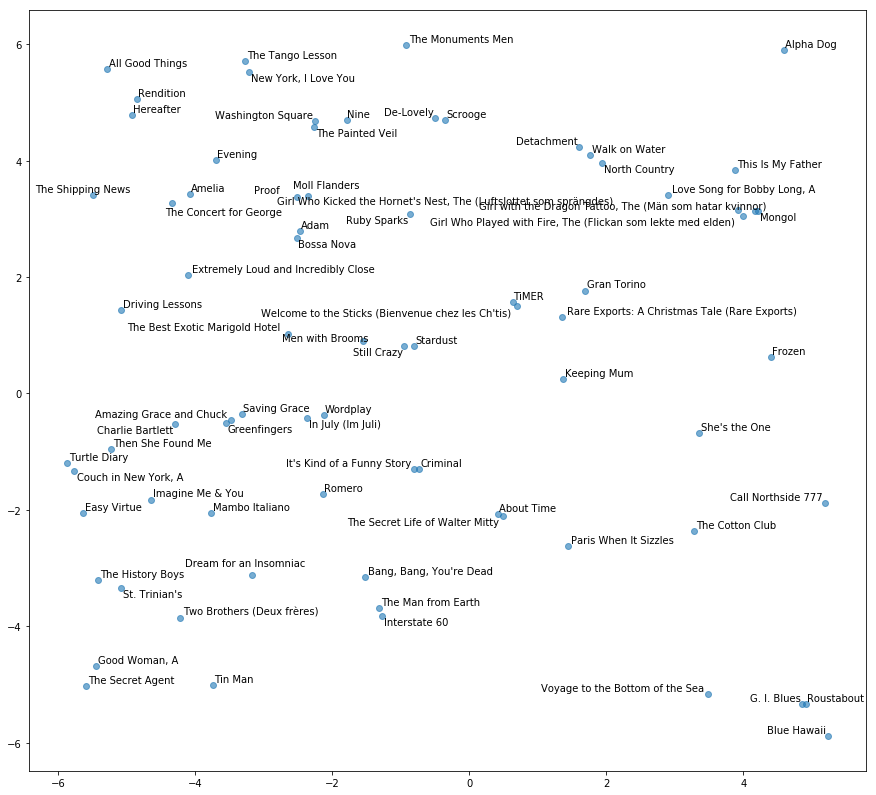

In [ ]:
FS = (15, 14)
def plot_region(x0, x1, y0, y1):
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    texts = []
    for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
        t = ax.annotate(label, xy=(x, y))
        texts.append(t)
    adjust_text(texts, expand_text=(1.01, 1.05))
    return ax

plot_region(-6, 6, -6, 6);

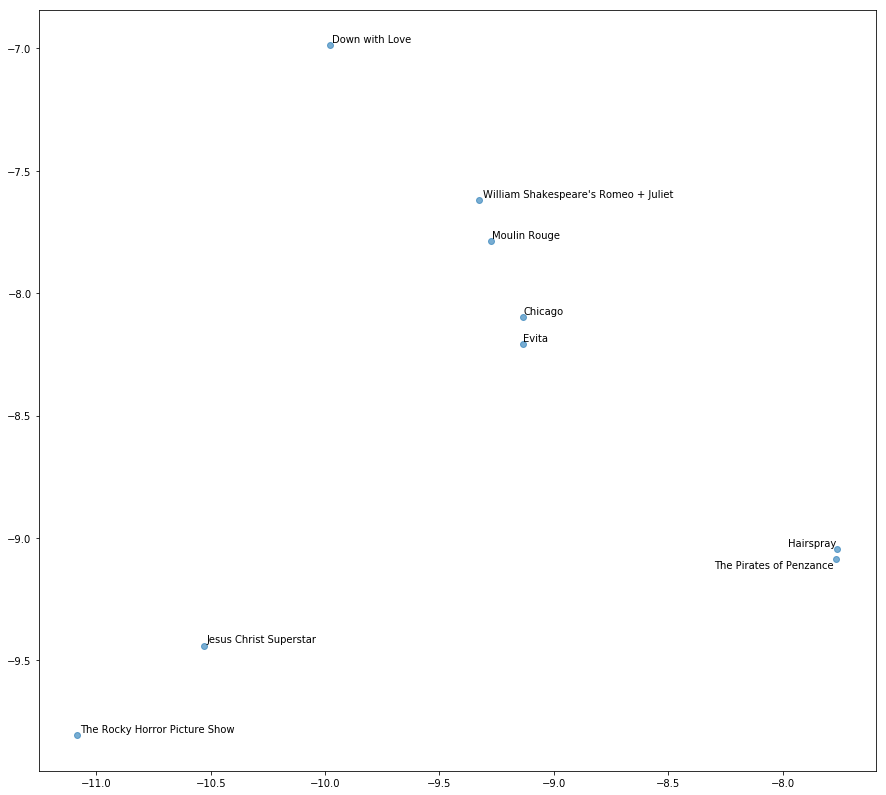

In [ ]:
def plot_region_around(title, xmargin=5, ymargin=5):
    match = df[df.title == title]
    assert len(match) == 1
    row = match.iloc[0]
    plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin)

plot_region_around('Chicago', 2, 2)

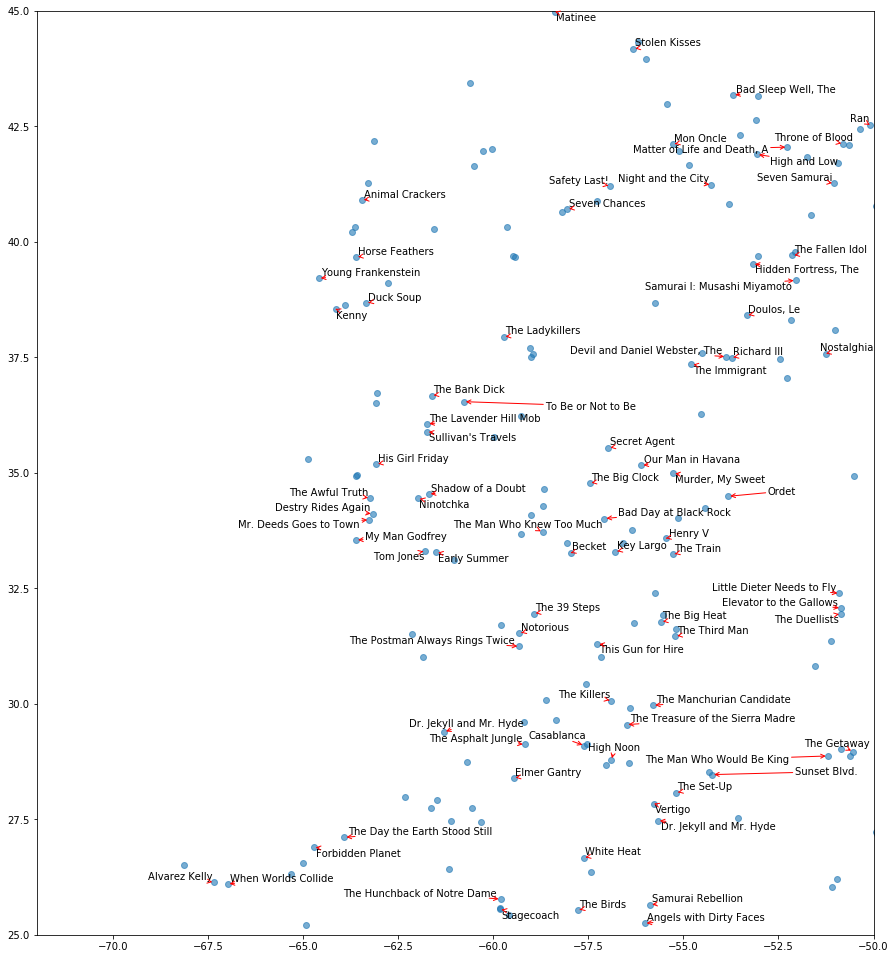

In [ ]:
def zoom(xlim, ylim, label_prob=1):
    FS = (15, 17)
    fig, ax = plt.subplots(figsize=FS)
    X = embs[:, 0]
    Y = embs[:, 1]
    ax.scatter(X, Y, alpha=.6);
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    texts = []
    random.seed(1)
    titles = mainstream_movies['title'].values
    for label, x, y in zip(titles, X, Y):
        if not (x > xlim[0] and x < xlim[1]) or not (y > ylim[0] and y < ylim[1]):
            continue
        if not random.random() < label_prob:
            continue
        if '(' in label:
                label = label[:label.find('(')-1]
        t = ax.annotate(label, xy=(x, y))
        texts.append(t)
    adjust_text(texts, expand_text=(1.01, 1.05),
                #arrowprops=dict(arrowstyle='->', color='red')
               )

# Top left ish cluster
zoom(
    (-72, -50),
    (25, 45),
    label_prob=.45,
)

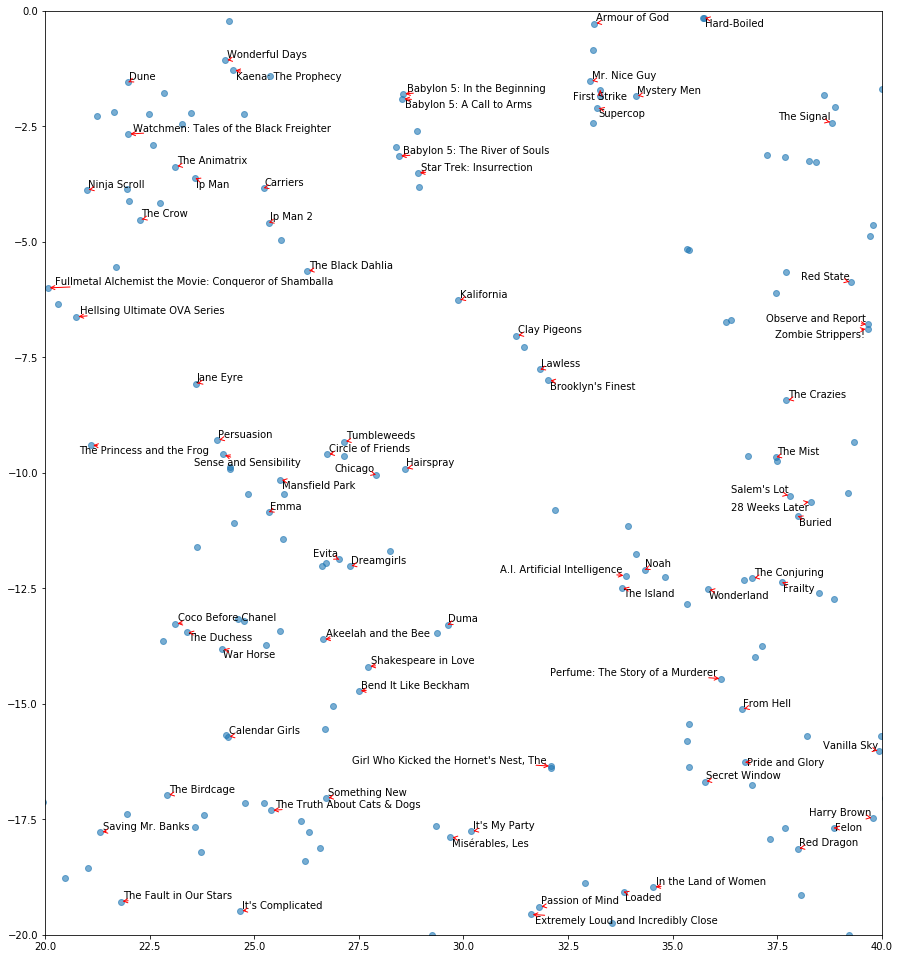

In [ ]:
zoom(
    (20, 40),
    (-20, -0),
    label_prob=.45,
)

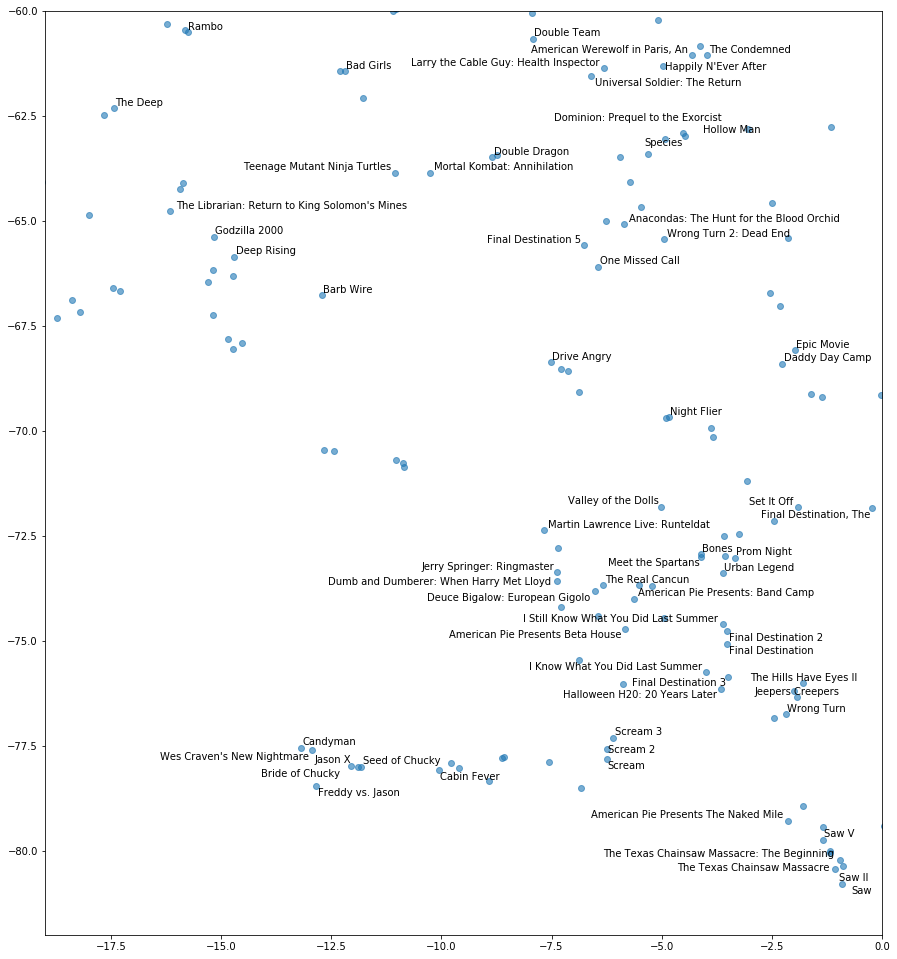

In [ ]:
zoom(
    (-19, 0),
    (-82, -60),
    label_prob=.45,
)

## Notes/scratch

tips:
- monitor training by setting verbose=1
- experiment with params. 
- train on all data
- distance metric?

- TODO: maybe try running on another dataset as well? Wouldn't be so hard. Probably.

- would be cool to color by genre, or by...
    - avg. rating
    - MPAA rating
    - year
- plot many/all points, and add labels for just a certain subset at a time. e.g. Adam Sandler movies. Best Picture winners. etc.
- try generating a few maps with the same params (but no fixed seed). See how much variation exists between them.

question: train on all datapoints, then sample the ones to visualize? Or only train on the subset you're planning on visualizing?

Relevant quote:

> Obviously, it is possible to
pick a random subset of the datapoints and display them using t-SNE, but such an approach fails to 
make use of the information that the undisplayed datapoints provide about the underlying manifolds.
Suppose, for example, that A, B, and C are all equidistant in the high-dimensional space. If there
are many undisplayed datapoints between A and B and none between A and C, it is much more
likely that A and B are part of the same cluster than A and C. 

further reading: http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf (how it works, why it's useful specifically for viz, how it's different from stuff like PCA)

sklearn t-sne user guide looks like a good resource: http://scikit-learn.org/stable/modules/manifold.html#t-sne

goals: https://distill.pub/2016/misread-tsne/